# MultilayerPy - crash course (version 0.0.1)

This is a rough guide to get MultilayerPy working on your machine. It will reproduce the output (roughly) from the KM-SUB description paper Fig. 2(a) (https://doi.org/10.5194/acp-10-3673-2010).

#### List of things to setup before starting:
1. Import the MultilayerPy folder to where you want to test the package (I'll send it as a .zip to you). Maybe a "model_builder" folder...
2. Open up a session in Spyder (if you don't have spyder, download Anaconda and open it from there). 
3. Make sure you have scipy and numpy installed. Check this by tring to run `import scipy` and `import numpy` in the ipython console window. If you don't have those: `pip install scipy` and/or `pip install numpy` should do it.

First of all we need to import all of the packages that we need. This is already done in the example.py file. This also imports the `build` and `simulate` files that are the basis of the package. 

In [1]:
# importing the necessaries
import numpy as np
import multilayerpy.build as build 
import multilayerpy.simulate as simulate
import multilayerpy.optimize as optimize
import scipy

### Defining the reaction scheme
The first thing to do is define the reaction scheme. In this case, **oleic acid + ozone --> products**. There are 3 components. 

To define the reaction scheme, a `reactant_tuple_list` and `product_tuple_list` is defined. These two objects are lists of tuples (tuple: `(a,b)`; list of tuples:`[(a,b), (c,d)]`). Each member of the list (tuple) represents reactants/product(s) of that reaction. **Both tuple lists need to be in the same order as the reaction scheme; i.e. reaction 2 needs to be after reaction 1 etc.**

In this simple case, there is only one reaction with 2 reactants and 1 product. All you need to do is assign a number to each of these. Here: oleic acid = 1, ozone = 2, products = 3.

Now we can build up the reaction scheme using the `ReactionScheme` object in MultilayerPy:

In [3]:
# import the ModelType class
from multilayerpy.build import ModelType

# import the ReactionScheme class
from multilayerpy.build import ReactionScheme

# define the model type (KM-SUB in this case) and geometry (spherical or film)
mod_type = ModelType('km-sub','spherical')

# build the reaction tuple list, in this case only 1 tuple in the list (for 1 reaction)
# component 1 (oleic acid) reacts with component 2 (ozone)
reaction_tuple_list = [(1,2)]

# build the product tuple list, only component 3 (products) is a product
# a tuple with a single value inside is defined (value,)
product_tuple_list = [(3,)]

# now construct the reaction scheme
# we can give it a name and define the nuber of components as below
reaction_scheme = ReactionScheme(mod_type,name='Oleic acid ozonolysis',
                                                   reactants=reaction_tuple_list,
                                                products=product_tuple_list)

# let's print out a representation of the reaction scheme
reaction_scheme.display()

#########################################################
Reaction scheme: Oleic acid ozonolysis
Model type: km-sub
** No stoichiometry shown **
R1: 1 + 2 -----> 3 
#########################################################


### Model components
Now we need to make the model components. This is done using the `ModelComponent` object in MultilayerPy. This needs to be supplied with the component number and reaction scheme. Optionally, we can give it a name. 

In [4]:
# import ModelComponent class
from multilayerpy.build import ModelComponent

# making model components

# oleic acid
OA = ModelComponent(1,reaction_scheme,name='Oleic acid')

# ozone, declare that it is a gas
O3 = ModelComponent(2,reaction_scheme,gas=True,name='Ozone') 

# products
prod = ModelComponent(3,reaction_scheme, name='Reaction products')

# collect into a dictionary
model_components_dict = {'1':OA,
                        '2':O3,
                        '3':prod}

### Diffusion 
This simple example does not consider diffusion as a function of particle composition. MultilayerPy does, however, have the capacity to account for this. 

We still need to declare that there is no diffusion evolution. A more detailed example of how to account for diffusion evolution will be provided in the future. 

Here, we will supply a Python dictionary with keys representing components and values of `None`, meaning there is no diffusion evolution. This is then fed into the `DiffusionRegime` object, which writes the code necessary to define diffusion for each component.

In [5]:
# import DiffusionRegime class
from multilayerpy.build import DiffusionRegime

# making the diffusion dictionary
diff_dict = {'1' : None,
             '2': None,
             '3':None}  

# make diffusion regime
diff_regime = DiffusionRegime(mod_type,model_components_dict,diff_dict=diff_dict)

# call it to build diffusion code ready for the builder
diff_regime()


### Construct the model
Now we can construct the model using `ModelBuilder` in MultilayerPy. This requires the `reaction_scheme`, `model_components_dict` and `diff_regime` defined earlier.

In [6]:
# import ModelBuilder class
from multilayerpy.build import ModelBuilder

# create the model object, ignore [1,2,3] etc at the end
model = ModelBuilder(reaction_scheme,model_components_dict,diff_regime)

# build the model. Will save a file, don't include the date in the model filename
model.build(date=False)

# print out the parameters required for the model to run
print(model.req_params)

{'Db_1', 'Db_2', 'Db_3', 'alpha_s_0_2', 'w_2', 'Td_2', 'T', 'delta_2', 'Xgs_2', 'k_1_2_surf', 'k_1_2', 'H_2', 'delta_3', 'delta_1'}


### Running the model
Models are run using the `Simulate` object in MultilayerPy. 

The required parameters need to be supplied as a dictionary. I am working on getting the user to supply a spreadsheet/.csv file with this information for easier usability. For the moment, I have made a dictionary.

A description of each parameter will be supplied separately in the documentation. 

All we need to do is supply: 
* the parameter dictionary
* number of model layers
* radius of the particle/thickness of the film
* time span to run the model
* number of timepoints to save
* Volume and surface area of each model layer
* Initial concentrations of every component in the film

**This is currently the most involved part of things. I have ideas for making this easier in the future.**


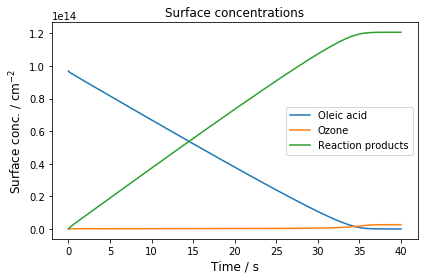

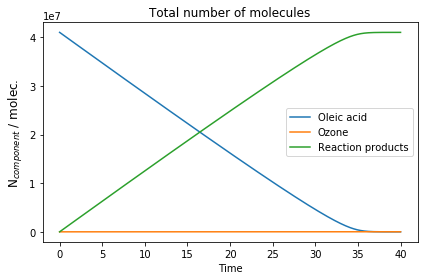

In [7]:
# import the Simulate class
from multilayerpy.simulate import Simulate

# import the Parameter class
from multilayerpy.build import Parameter

# make the parameter dictionary
# these are parameters from the KM-SUB model description paper (see reference at the start of this notebook)
param_dict = {'delta_3':Parameter(1e-7),
              'alpha_s_0_2':Parameter(4.2e-4),
              'delta_2':Parameter(0.4e-7),
              'Db_2':Parameter(1e-5),
              'delta_1':Parameter(0.8e-7),
              'Db_1':Parameter(1e-10),
              'Db_3':Parameter(1e-10),
              'k_1_2':Parameter(1.7e-15),
              'H_2':Parameter(4.8e-4),
              'Xgs_2': Parameter(7.0e13),
              'Td_2': Parameter(1e-2),
              'w_2':Parameter(3.6e4),
              'T':Parameter(298.0),
              'k_1_2_surf':Parameter(6.0e-12)}

# make the simulate object with the model and parameter dictionary
sim = Simulate(model,param_dict)

# define required parameters
n_layers = 10
rp = 0.2e-4 # radius in cm
time_span = [0,40] # in s
n_time = 999 # number of timepoints to save to output

#spherical V and A
# use simulate.make_layers function
V, A, layer_thick = simulate.make_layers(mod_type,n_layers,rp)

# initial conc. of everything

bulk_conc_dict = {'1':1.21e21,'2':0,'3':0} # key=model component number, value=bulk conc
surf_conc_dict = {'1':9.68e13,'2':0,'3':0} # key=model component number, value=surf conc

y0 = simulate.initial_concentrations(mod_type,bulk_conc_dict,surf_conc_dict,n_layers) 
    
# now run the model
output = sim.run(n_layers,rp,time_span,n_time,V,A,layer_thick,Y0=y0)

%matplotlib inline
# plot the model
sim.plot()

In [ ]:
# uncomment the line below to see what params were used to run the model simulation
#sim.run_params

## Visualisation of model outputs
Now we have a model which has been run. The `Simulate` object has stored the time resolved surface and bulk concentrations for each model layer and component. These are easily accessible through `Simulate.surf_concs` and `Simulate.bulk_concs`. These are dictionaries, with keys corresponding to the component number. 

Let's access the bulk concentration of oleic acid and plot it as a heatmap. Here is the long way of doing it, allowing for customization: 

shape before transposition (999, 10)
shape after transposition (10, 999)


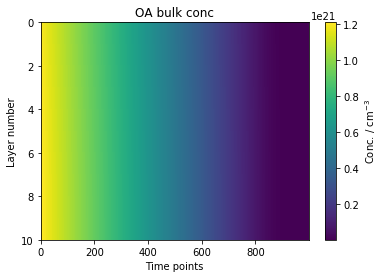

In [8]:
# get the bulk concentration array for oleic acid (component number 1)
OA_bulk_conc_arr = sim.bulk_concs['1']

# print the shape of the array (n_time,n_layers)
print('shape before transposition',OA_bulk_conc_arr.shape)

# I want the layers to be the rows, time as columns
OA_bulk_conc_arr = OA_bulk_conc_arr.T # transpose
print('shape after transposition',OA_bulk_conc_arr.shape)

# Now let's plot the heatmap
# import pyplot
import matplotlib.pyplot as plt

plt.figure()
plt.title('OA bulk conc')
plt.pcolormesh(OA_bulk_conc_arr)
plt.xlabel('Time points')
plt.ylabel('Layer number')

# invert y-axis so that layer 0 is at the top of the plot
plt.gca().invert_yaxis()
plt.colorbar(label='Conc. / cm$^{-3}$')
plt.show()


### Quick plotting
The `Simulate` object has a `plot_bulk_concs()` function which will return heatmap plots of the bulk concentration for each model component during the model run.  

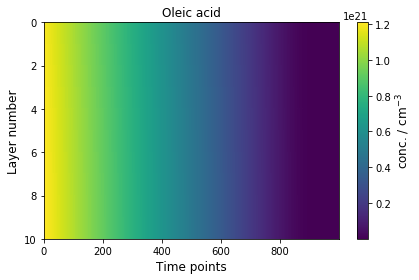

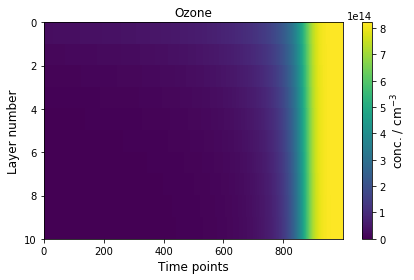

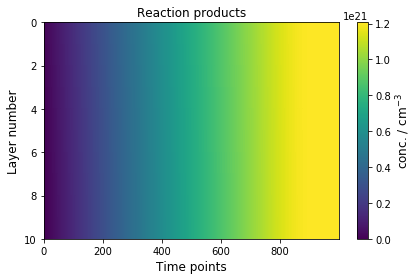

In [9]:
sim.plot_bulk_concs()

## Model optimization - fitting the model to some data

Now that we have a working model, it is likely that we would want to fit the model to some real-world data. This involves creating an `Optimizer` object which will take a `Simulate` object and some `Data` as inputs. 

### Current options for parameter optimization:
* **Local minimization** with a simplex Nealder-Mead algorithm (a `scipy.optimize.minimise` method).
* **Global minimization** with a differential evolution algorithm (`scipy.optimize.differential_evolution`)

There is a `noisy_data.txt` file which accompanies this notebook. This is noisy data generated from the model output we plotted earlier. In this way we know the "true" value of the parameters we are tring to optimize. 

In order to optimize parameters we need to convert the values of the `simulate.parameters` dictionary into `Parameter` objects. 

Let's say we didn't have a good idea of the surface accommodation coefficient (alpha_s0_2) for ozone (component 2):

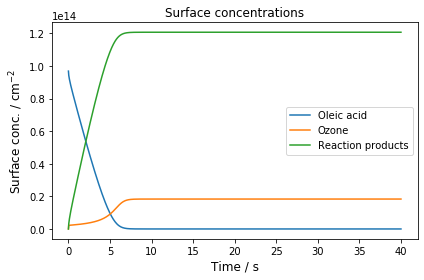

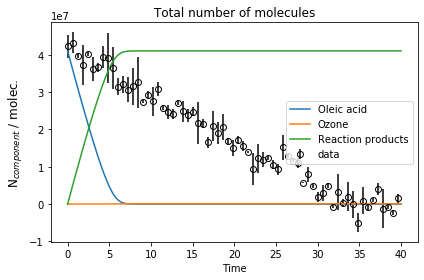

In [10]:
# import the optimize module and Optimizer object
import multilayerpy.optimize
from multilayerpy.optimize import Optimizer


# I'll adjust the sim.parameters dictionary to change alpha_s0 to something wrong
# note that 'alpha_s0_2' is set to vary with some bounds

param_dict = {'delta_3':Parameter(1e-7),
              'alpha_s_0_2':Parameter(0.003,vary=True,bounds=(1e-4,1.0)),
              'Db_2_1':Parameter(1e-5),
              'kd_X_2':Parameter(1.0/1e-2),
              'Db_2_3':Parameter(1e-10),
              'scale_bulk_to_surf':Parameter(4.41e6),
              'W_2':Parameter(3.6e4),
              'delta_2':Parameter(0.4e-7),
              'Db_2':Parameter(1e-5),
              'delta_1':Parameter(0.8e-7),
              'Db_1':Parameter(1e-10),
              'Db_3':Parameter(1e-10),
              'k_1_2':Parameter(1.7e-15),
              'H_2':Parameter(4.8e-4),
              'Xgs_2': Parameter(7.0e13),
              'Td_2': Parameter(1e-2),
              'w_2':Parameter(3.6e4),
              'T':Parameter(298.0),
              'k_1_2_surf':Parameter(6e-12)}

# for now, a new simulate object will be created from the original model and the new param_dict
sim = Simulate(model,param_dict)

# let's load in the fake noisy data - columns are (time, y, y_error)
fake_data = np.genfromtxt('noisy_data.txt')

# set the Simulate.data attribute to be the fake data, using the Data object and normalised
from multilayerpy.simulate import Data
sim.data = Data(fake_data,norm=True)

# run the model and plot the initial output
output = sim.run(n_layers,rp,time_span,n_time,V,A,layer_thick,Y0=y0)
sim.plot()


In [11]:
# the oleic acid decay is way too fast
# create an optimizer object which will vary alpha_s0_2. I've called it "fitter" here
from multilayerpy.optimize import Optimizer

fitter = Optimizer(sim)

# fit the model + experiment, default method is simplex (least-squares)
# the fitter will default to fitting the output from component 1 (oleic acid) to the data 
#(see the user manual for how to change this)
# this will take a few moments...
res = fitter.fit()



Optimising using least_squares Nelder-Mead algorithm...

Optimization terminated successfully.
         Current function value: 0.002661
         Iterations: 11
         Function evaluations: 22
optimised params:

{'alpha_s_0_2': 0.00041250000000000824}

Success=: True ,termination message: Optimization terminated successfully.
number of iters: 11
final cost function value = 
0.0026610005870076367


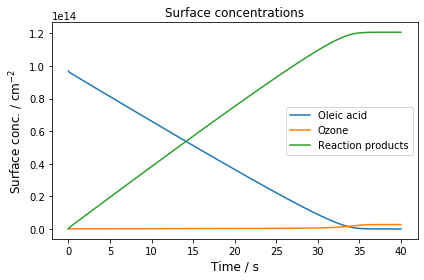

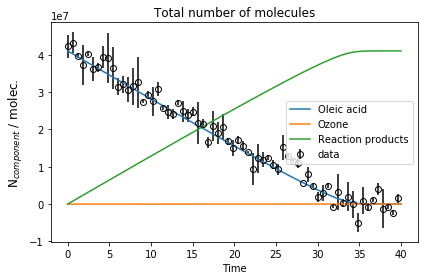

In [12]:
# Plot the optimised model
sim.plot()


As you can see, the modelled oleic acid decay now fits very well to the experiment. Moreover, the fitted value of `alpha_s0_2` was optimized as ~0.0004 which is very close to the original value (4.2e-4) which was used to generate the fake data! 

Any number of the parameters in the parameter dictionary can be varied. Just set `vary = True` and `bounds = (lower_bound,upper_bound)` for the `Parameter` object you would like to optimise (see above). 

## Summary

This was a quick walkthrough to get you started with MultilayerPy and KM-SUB. In just a few lines of code a model was created, run and optimised. A separate tutorial using KM-GAP will accompany this crash course - it is essentially the same process, just with a few extra considerations. 

A few points:

* It is easy to make the model fall over if you supply the model with unrealistic parameters. Think about the input parameters for your model. 
* The model takes longer to run when adding more model layers and model components. 
* Optimisation using the least-squares algorithm requires the initial values of the varying parameters to fall within the bounds you give them. Otherwise, there is a warning. 
* The model code file defining the ODEs can be used as part of the supporting information for a publication. For a reminder of the model filename, use the `ModelBuilder.filename` attribute of the model you created. In this example case `model.filename` will print the model filename (`model` is a `ModelBuilder` instance). 


For more information about the other features of MultilayerPy and the objects within it, consult the **user manual** and the other examples which accompany the source code. 